In [1]:
from __future__ import annotations

import numpy as np
import pandas as pd

from typing import *

In [2]:
from nepal.datasets import NYTimes, PopulationDensity
from nepal.ml.preprocess import Cases, Population

df: pd.DataFrame = Cases(NYTimes()).preprocessed()
extra_pop: pd.DataFrame = Population(PopulationDensity()).preprocessed()

In [7]:
from typing import Callable, NamedTuple

from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    MeanAbsoluteError,
)


class Loss(NamedTuple):
    name: str
    function: Callable


mae = Loss(
    name="mean_absolute_error",
    function=MeanAbsoluteError(),
)

mape = Loss(
    name="mean_absolute_percentage_error",
    function=MeanAbsolutePercentageError(symmetric=True),
)

In [13]:
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter
from nepal.ml.validate import cross_validate

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=18)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[extra_pop], loss=mape.function
)
print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

                  new_cases_1  new_cases_2  new_cases_3  new_cases_4  \
fips  date                                                             
01001 2020-05-20            7          0.0          7.0          0.0   
01003 2020-05-20            2          0.0         10.0          1.0   
01005 2020-05-20            5          2.0          0.0          5.0   
01007 2020-05-20            1          0.0          1.0          3.0   
01009 2020-05-20            0          1.0          0.0          0.0   
...                       ...          ...          ...          ...   
72151 2020-05-20            1          0.0          0.0          0.0   
72153 2020-05-20            3          1.0          0.0          3.0   
78010 2020-05-20            0          0.0          0.0          0.0   
78020 2020-05-20            0          0.0          0.0          0.0   
78030 2020-05-20            0          0.0          0.0          0.0   

                  new_cases_5  new_cases_6  new_cases_7  new_ca

In [9]:
# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(objective=mape.name), lag=18)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], loss=mape.function
)
print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

1.2404529768111228


<AxesSubplot:>

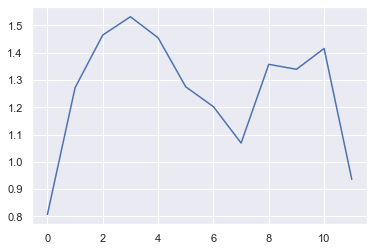

In [14]:
import seaborn as sns

sns.set(style="darkgrid")
sns.lineplot(data=scores)

In [15]:
from sklearn.pipeline import Pipeline
from nepal.ml.transformers import RollingWindowSum

transformers: Pipeline = Pipeline(
    [
        (
            "with_active_infections",
            RollingWindowSum("new_cases", target="infections", window=10),
        ),
    ]
)

In [ ]:
import optuna


def objective(trial: optuna.Trial) -> float:
    lag = trial.suggest_int("lag", 10, 24)
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=lag, transformers=transformers
    )

    scores: Sequence[float] = cross_validate(
        forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[extra_pop], loss=mape.function
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10)

study.best_params
# Best found lag value with default LGBM params: 18

In [16]:
from nepal.graph import Connection, LocalConnection

conn: Connection = LocalConnection(
    database="neo4j",
    password="corona",
)

assert conn.is_up()

In [ ]:
import optuna
import lightgbm as lgb
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import SlidingWindowSplitter

from nepal.ml.forecaster import LGBMForecaster
from nepal.ml.splitter import Splitter

from nepal.graph.gds import CountyEmbedding


embedding = CountyEmbedding()
embedding.create_projection(conn)

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)


def objective(trial: optuna.Trial) -> float:
    forecaster = LGBMForecaster(
        lgb.LGBMRegressor(objective=mape.name), lag=18, transformers=transformers
    )

    neo4j: pd.DataFrame = embedding.load_dataframe(
        connection=conn,
        embedding_dimension=trial.suggest_int("dim", 128, 512, log=True),
        weight2=trial.suggest_float("weight2", 0.0, 1.0),
        weight3=trial.suggest_float("weight3", 0.0, 1.0),
        weight4=trial.suggest_float("weight4", 0.0, 1.0),
        normalization=trial.suggest_float("normalization", -1.0, 1.0),
        property_ratio=trial.suggest_float("prop_ratio", 0.0, 1.0),
        self_influence=trial.suggest_float("self_influence", 0.0, 1.0),
    )

    scores: Sequence[float] = cross_validate(
        forecaster,
        splitter=splitter,
        y=df[["new_cases"]],
        Xs=[extra_pop, neo4j],
        loss=mape.function,
    )
    return np.mean(scores)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

study.best_params
# Best found values with default LGBM params and lag=12:
# {'dim': 13,
#  'weight2': 0.9095431576049532,
#  'weight3': 0.3804723961743889,
#  'weight4': 0.9975167117131349,
#  'normalization': -0.9871365897384008,
#  'prop_ratio': 0.12685783148389826,
#  'self_influence': 0.44962816623765073}

/Users/personal/Documents/Master of Statistics/2/Modern Data Analytics/Project/G0Z39a/src/nepal/graph/gds/embedding.py:73: UserWarning: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.project`: Caused by: java.lang.IllegalArgumentException: A graph with name 'counties' already exists.}
  warnings.warn(str(e))
[I 2022-06-02 21:25:04,381] A new study created in memory with name: no-name-57e03020-97ec-4bf4-acce-d3d410597f1f


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-02 21:35:33,874] Trial 0 finished with value: 1.214076252986109 and parameters: {'dim': 408, 'weight2': 0.39278214194521766, 'weight3': 0.8137099329508811, 'weight4': 0.3071328418127124, 'normalization': 0.2372850761336367, 'prop_ratio': 0.26756988069025145, 'self_influence': 0.678000929249061}. Best is trial 0 with value: 1.214076252986109.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

[I 2022-06-02 21:43:19,912] Trial 1 finished with value: 1.2125646198488904 and parameters: {'dim': 210, 'weight2': 0.4220780500930186, 'weight3': 0.32985761428142546, 'weight4': 0.5968719136353636, 'normalization': 0.45863988740932604, 'prop_ratio': 0.1431323571731158, 'self_influence': 0.10243912001333766}. Best is trial 1 with value: 1.2125646198488904.


Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

In [13]:
# Evaluate found parameters

fh = ForecastingHorizon(list(range(1, 15)))
cv = SlidingWindowSplitter(fh=fh, window_length=120, step_length=60)
splitter: Splitter = Splitter(cv)

# Create regressor with default parameters
forecaster = LGBMForecaster(lgb.LGBMRegressor(), lag=12)
embedding = CountyEmbedding()

X: pd.DataFrame = embedding.load_dataframe(
    connection=conn,
    embedding_dimension=16,
    weight2=0.9,
    weight3=0.4,
    weight4=1.0,
    normalization=-1.0,
    property_ratio=0.15,
    self_influence=0.45,
)

scores: Sequence[float] = cross_validate(
    forecaster, splitter=splitter, y=df[["new_cases"]], Xs=[X]
)

print(np.mean(scores))

Train/Test split:   0%|          | 0/12 [00:00<?, ?it/s]

1.1615128487786013
